# Exoplanet Detection with Keras


William Gilpin MLND


In [99]:
# Import the libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

In [100]:
# import keras modules
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

## Load the data

In [101]:
INPUT_LIB = './'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

Normalise all samples for mean and sd.

In [102]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [103]:
x_train.shape

(5087, 3197)

In [104]:
print(x_train[1])

[-0.52418682 -0.44002245 -0.85184454 ...  0.23145922  0.39045488
  0.45595309]


Next we add an input corresponding to the running average over
200 time steps. This helps the net ignore high frequency noise and instead look at non-local
information.

In [105]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

# Exploration

In [106]:
plt.style.use('seaborn-whitegrid')

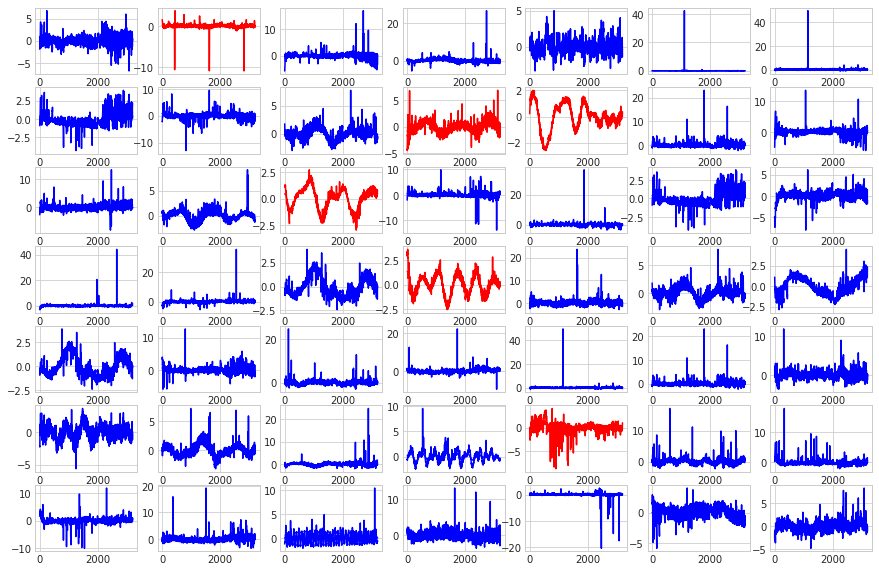

In [107]:
import random
random.seed(42)
n_x = 7
fig, ax = plt.subplots(n_x, n_x, figsize=(15,10))
for rowIdx, row in enumerate(ax):
    for colIdx, col in enumerate(row):
        n = random.randint(0,300)
        y = y_train[n]
        col.plot(x_train[n], color = 'red' if y else 'blue' )

## Train the model

In [108]:
#functional model
from keras import Input

# input layer
conv_inputs = Input(shape=x_train.shape[1:])

# 1st feature extractor
conv1 = Conv1D(filters=8, kernel_size=21, activation='relu')(conv_inputs)
pool1 = MaxPool1D(strides=4)(conv1)
batch1 = BatchNormalization()(pool1)

# 2nd feature extractor
conv2 = Conv1D(filters=16, kernel_size=21, activation='relu')(batch1)
pool2 = MaxPool1D(strides=4)(conv2)
batch2 = BatchNormalization()(pool2)

# 3rd feature extractor
conv3 = Conv1D(filters=32, kernel_size=21, activation='relu')(batch2)
pool3 = MaxPool1D(strides=4)(conv3)
batch3 = BatchNormalization()(pool3)

# 4th feature extractor
conv4 = Conv1D(filters=64, kernel_size=21, activation='relu')(batch3)
pool4 = MaxPool1D(strides=4)(conv4)

# flatten feature extractors
flat1 = Flatten()(pool4)
drop1 = Dropout(0.5)(flat1)

# interpretation layers
dense1 = Dense(64, activation='relu')(drop1)
drop2 = Dropout(0.25)(dense1)
dense2 = Dense(64, activation='relu')(drop2)

# prediction
output_layer = Dense(1, activation='sigmoid')(dense2)

#model
f_model = Model(inputs=conv_inputs, outputs=output_layer)

print(f_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3197, 2)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3177, 8)           344       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 794, 8)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 794, 8)            32        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 774, 16)           2704      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 194, 16)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 194, 16)           64        
__________

The data here is extremely unbalanced, with only a few positive examples. To correct for this use the positive examples a lot more often, so that the net sees 50% of each over each bats. Also, generate new examples by rotation them randomly in time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [58]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [12]:
#Start with a slightly lower learning rate, to ensure convergence
f_model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [13]:
hist = f_model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

In [14]:
#Then speed things up a little
f_model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = f_model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40
 - 3s - loss: 0.7053 - acc: 0.5455 - val_loss: 0.5276 - val_acc: 0.8860
Epoch 2/40
 - 2s - loss: 0.6830 - acc: 0.5881 - val_loss: 0.5029 - val_acc: 0.8842
Epoch 3/40
 - 2s - loss: 0.6608 - acc: 0.6035 - val_loss: 0.4814 - val_acc: 0.8772
Epoch 4/40
 - 2s - loss: 0.6362 - acc: 0.6294 - val_loss: 0.4454 - val_acc: 0.8754
Epoch 5/40
 - 2s - loss: 0.6256 - acc: 0.6465 - val_loss: 0.4287 - val_acc: 0.8632
Epoch 6/40
 - 2s - loss: 0.6070 - acc: 0.6588 - val_loss: 0.4113 - val_acc: 0.8614
Epoch 7/40
 - 2s - loss: 0.6083 - acc: 0.6648 - val_loss: 0.3867 - val_acc: 0.8702
Epoch 8/40
 - 2s - loss: 0.6032 - acc: 0.6673 - val_loss: 0.3855 - val_acc: 0.8737
Epoch 9/40
 - 2s - loss: 0.5887 - acc: 0.6850 - val_loss: 0.3751 - val_acc: 0.8754
Epoch 10/40
 - 2s - loss: 0.5807 - acc: 0.6910 - val_loss: 0.3590 - val_acc: 0.8842
Epoch 11/40
 - 2s - loss: 0.5644 - acc: 0.6954 - val_loss: 0.3437 - val_acc: 0.8807
Epoch 12/40
 - 2s - loss: 0.5533 - acc: 0.7061 - val_loss: 0.3304 - val_acc: 0.8825
E

In [52]:
f_model.save_weights('f_model.dat')

#Evaluate the model

First we look at convergence

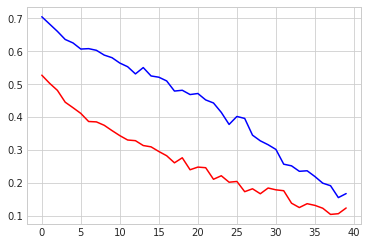

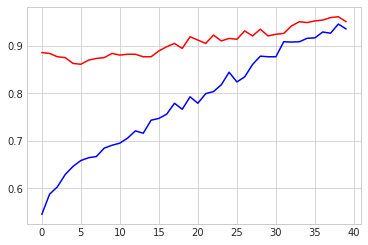

In [15]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

We then use our trained net to classify the test set.

In [16]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = f_model.predict(x_test)[:,0]

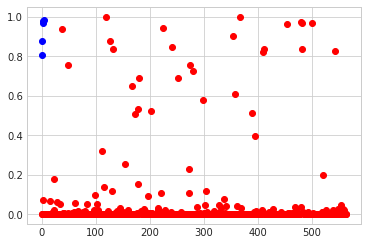

In [17]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')

plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Most negative examples get score close to zero, but an unsatisfactory number are in the same range as the true positives

We now choose an optimal ccossover point for classification.

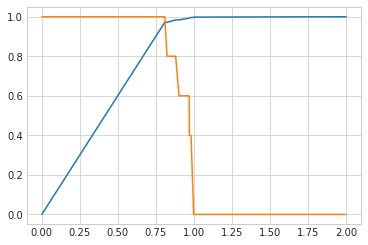

Crossover at 0.81 with specificity 0.97


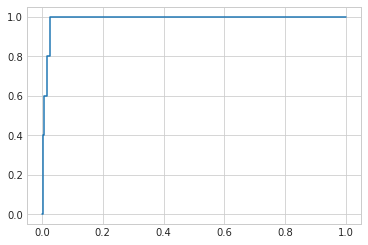

ROC area under curve is 0.99


In [18]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

In [80]:
false_positives = np.where(y_hat * (1. - y_test) > crossover_cutoff)[0]
plt.close()
for i in non_idx[0:10]:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

In [136]:
from collections import Counter

def compare(bool_pair):
    # from a pair= (y_predicted, y_actual) return the quadrant code
    if bool_pair[0] == bool_pair[1]:
        return 'TP' if bool_pair[0] else 'TN'
    return 'FP'if bool_pair[0] else 'FN'
    
def F1_score(y_hat, y_true, crossover=0.5):
#     set_trace()
    
    bool_true = [y[0] >= crossover for y in y_test]
    
    q = Counter([compare(y) for y in zip(y_hat, bool_true)])
    
    precision = q['TP'] / (q['TP'] + q['FP']) if q['TP'] + q['FP'] != 0 else 0.
    recall = q['TP'] / (q['TP'] + q['FN']) if q['TP'] + q['FN'] != 0 else 0.
    F1 = 2 * precision * recall / (precision + recall)if precision + recall != 0 else 0.
        
    print ("found: ",q['TP']+q['FP'])
    print ("actual: ",q['TP'] + q['FN'])
    print ("missed: ",q['FN'])
    print ("precision: ",precision)
    print ("recall: ",recall)
    print ("F1: ",F1)
    return F1

def F1_score_1hot(y_hat_1hot, y_true):
    bool_hat = [y[0] >= y[1] for y in y_hat_1hot]
    return F1_score(bool_hat, y_true)

In [82]:
F1_score([y > 0.5 for y in y_hat], y_test, crossover_cutoff)

found:  3
actual:  5
missed:  4
precision:  0.3333333333333333
recall:  0.2
F1:  0.25


0.25

# FFT

In [10]:
INPUT_LIB = './'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train_fft_raw = raw_data[:, 1:]
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test_fft_raw = raw_data[:, 1:]
del raw_data
x_train_fft_raw.shape

(5087, 3197)

In [11]:
from scipy import fft
import random

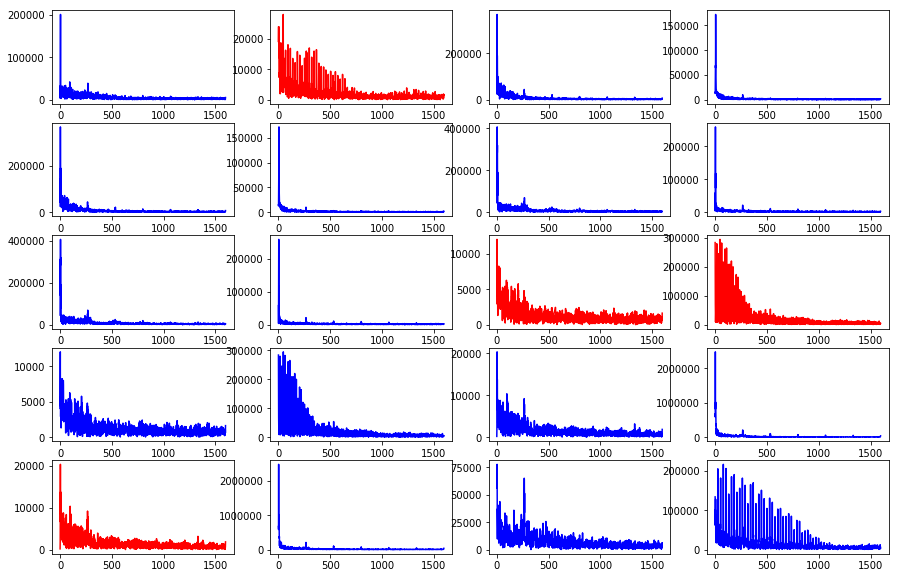

In [12]:
fft_n = 20
exFft = np.abs(fft(x_train_fft_raw[0:fft_n,:]))

random.seed(42)
fig, ax = plt.subplots(5, 4, figsize=(15,10))
nyquist = exFft.shape[1] // 2
for rowIdx, row in enumerate(ax):
    for colIdx, col in enumerate(row):
        fft_data = exFft[2*rowIdx+colIdx]
        n = random.randint(0,300)
        y = y_train[n]
        col.plot(range(nyquist), fft_data[0:nyquist], color = 'red' if y else 'blue')

In [13]:
x_train_fft_all = fft(x_train_fft_raw[1])
print(x_train_fft_all.shape)
nyquist = x_train_fft_all.shape[0] // 2
x_train_fft = np.delete(np.abs(fft(x_train_fft_raw)), np.s_[nyquist:nyquist*2], axis=1)
x_test_fft = np.delete(np.abs(fft(x_test_fft_raw)), np.s_[nyquist:nyquist*2], axis=1)
print('x_train_fft',x_train_fft.shape)
x_train_fft = np.stack([x_train_fft], axis=2)
x_test_fft = np.stack([x_test_fft], axis=2)

(3197,)
x_train_fft (5087, 1599)


In [14]:
# input shape
batch = None
steps = 1
input_dim = x_train_fft.shape[1]
fft_input_shape = (input_dim,1)
fft_input_shape

(1599, 1)

In [15]:
x_train_fft.shape

(5087, 1599, 1)

In [110]:
from keras.layers import CuDNNLSTM

fft_inputs = Input(shape=fft_input_shape, name='main_input')
x = CuDNNLSTM(75, return_sequences=True, name='L1')(fft_inputs)
x = CuDNNLSTM(37, name='L2')(x)
x = Dense(25, name='M1')(x)
fft_final = Dropout(0.5)(x)
output = Dense(1, name='D1')(fft_final)
fft_model = Model(fft_inputs, output)
fft_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 1599, 1)           0         
_________________________________________________________________
L1 (CuDNNLSTM)               (None, 1599, 75)          23400     
_________________________________________________________________
L2 (CuDNNLSTM)               (None, 37)                16872     
_________________________________________________________________
M1 (Dense)                   (None, 25)                950       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
D1 (Dense)                   (None, 1)                 26        
Total params: 41,248
Trainable params: 41,248
Non-trainable params: 0
_________________________________________________________________


In [90]:
fft_model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
print(x_train_fft.shape)

(5087, 1599, 1)


In [91]:
hist = fft_model.fit_generator(batch_generator(x_train_fft, y_train, 32), 
                           validation_data=(x_test_fft, y_test), 
                           verbose=2, epochs=10,
                           steps_per_epoch=x_train_fft.shape[1]//32)

Epoch 1/10
 - 17s - loss: 3.4264 - acc: 0.4745 - val_loss: 0.3964 - val_acc: 0.9912
Epoch 2/10
 - 16s - loss: 3.4640 - acc: 0.4745 - val_loss: 0.3919 - val_acc: 0.9912
Epoch 3/10
 - 16s - loss: 3.3409 - acc: 0.4758 - val_loss: 0.3887 - val_acc: 0.9912
Epoch 4/10
 - 16s - loss: 3.3460 - acc: 0.4853 - val_loss: 0.3929 - val_acc: 0.9912
Epoch 5/10
 - 16s - loss: 3.1887 - acc: 0.4675 - val_loss: 0.6192 - val_acc: 0.5316
Epoch 6/10
 - 16s - loss: 3.3340 - acc: 0.4592 - val_loss: 0.5085 - val_acc: 0.6000
Epoch 7/10
 - 16s - loss: 3.2748 - acc: 0.4815 - val_loss: 0.4387 - val_acc: 0.7509
Epoch 8/10
 - 16s - loss: 3.1166 - acc: 0.4834 - val_loss: 0.4728 - val_acc: 0.7386
Epoch 9/10
 - 16s - loss: 2.8503 - acc: 0.5013 - val_loss: 0.5301 - val_acc: 0.7702
Epoch 10/10
 - 16s - loss: 3.0884 - acc: 0.4847 - val_loss: 0.5671 - val_acc: 0.8316


In [92]:
fft_model.save_weights('fft_model.dat')

In [93]:
fft_model.load_weights('fft_model.dat')

In [94]:
y_hat_fft = fft_model.predict(x_test_fft)

In [139]:
F1_score(y_hat_fft, y_test)

found:  570
actual:  0
missed:  0
precision:  0.0
recall:  0.0
F1:  0.0


0.0

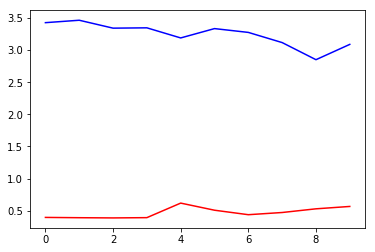

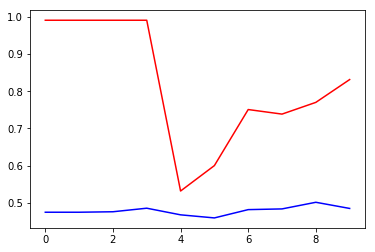

In [96]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [87]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]

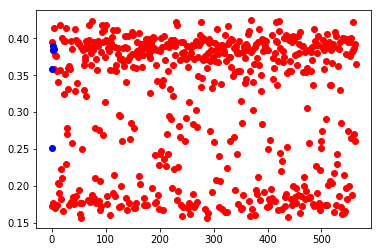

In [88]:
plt.plot([y_hat_fft[i] for i in non_idx], 'ro')
plt.plot([y_hat_fft[i] for i in yes_idx], 'bo')
plt.show()

# Composite model

In [111]:
concatenated = concatenate([fft_final, dense2])
answer = Dense(1, activation='sigmoid')(concatenated)
composite_model = Model([conv_inputs, fft_inputs], answer)
composite_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3197, 2)      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 3177, 8)      344         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 794, 8)       0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 794, 8)       32          max_pooling1d_4[0][0]            
__________________________________________________________________________________________________
conv1d_6 (

In [112]:
print(x_train.shape, x_train_fft.shape)

(5087, 3197, 2) (5087, 1599, 1)


In [113]:
composite_model.compile(optimizer=Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])

In [115]:
hist = composite_model.fit([x_train, x_train_fft], y_train, epochs=5)

Epoch 1/5
5087/5087 [==============================] - 49s 10ms/step - loss: 0.0303 - acc: 0.9927
Epoch 2/5
5087/5087 [==============================] - 49s 10ms/step - loss: 0.0275 - acc: 0.9927
Epoch 3/5
5087/5087 [==============================] - 49s 10ms/step - loss: 0.0267 - acc: 0.9927
Epoch 4/5
5087/5087 [==============================] - 49s 10ms/step - loss: 0.0218 - acc: 0.9925
Epoch 5/5
5087/5087 [==============================] - 49s 10ms/step - loss: 0.0199 - acc: 0.9933


In [43]:
composite_model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [124]:
def batch_generator_multi(x_train1, x_train2, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly
    """
    half_batch = batch_size // 2
    x_batch1 = np.empty((batch_size, x_train1.shape[1], x_train1.shape[2]), dtype='float32')
    x_batch2 = np.empty((batch_size, x_train2.shape[1], x_train2.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch1[:half_batch] = x_train1[yes_idx[:half_batch]]
        x_batch1[half_batch:] = x_train1[non_idx[half_batch:batch_size]]
        x_batch2[:half_batch] = x_train2[yes_idx[:half_batch]]
        x_batch2[half_batch:] = x_train2[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch1.shape[1])
            x_batch1[i] = np.roll(x_batch1[i], sz, axis = 0)
            x_batch2[i] = np.roll(x_batch2[i], sz, axis = 0)
     
        yield [x_batch1, x_batch2], y_batch

In [125]:
hist = composite_model.fit_generator(batch_generator_multi(x_train, x_train_fft, y_train, 32), 
                           validation_data=([x_test, x_test_fft], y_test), 
                           verbose=2, epochs=10,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
 - 33s - loss: 0.7223 - acc: 0.7014 - val_loss: 0.2649 - val_acc: 0.8754
Epoch 2/10
 - 32s - loss: 0.4694 - acc: 0.7771 - val_loss: 0.2006 - val_acc: 0.9123
Epoch 3/10
 - 32s - loss: 0.3832 - acc: 0.8340 - val_loss: 0.2098 - val_acc: 0.9035
Epoch 4/10
 - 32s - loss: 0.3234 - acc: 0.8592 - val_loss: 0.1358 - val_acc: 0.9439
Epoch 5/10
 - 32s - loss: 0.2313 - acc: 0.9069 - val_loss: 0.1063 - val_acc: 0.9649
Epoch 6/10
 - 32s - loss: 0.2026 - acc: 0.9230 - val_loss: 0.0966 - val_acc: 0.9737
Epoch 7/10
 - 32s - loss: 0.1890 - acc: 0.9331 - val_loss: 0.0987 - val_acc: 0.9719
Epoch 8/10
 - 32s - loss: 0.1613 - acc: 0.9413 - val_loss: 0.1048 - val_acc: 0.9737
Epoch 9/10
 - 32s - loss: 0.1245 - acc: 0.9536 - val_loss: 0.1165 - val_acc: 0.9684
Epoch 10/10
 - 32s - loss: 0.1347 - acc: 0.9542 - val_loss: 0.1046 - val_acc: 0.9719


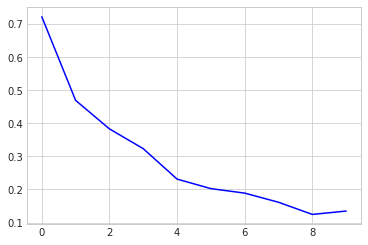

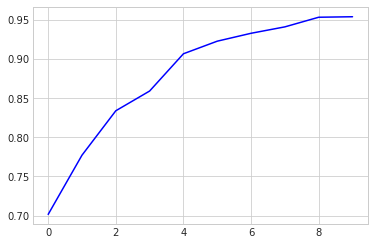

In [126]:
plt.plot(hist.history['loss'], color='b')
#plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
#plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [127]:
composite_model.save_weights('composite.dat')

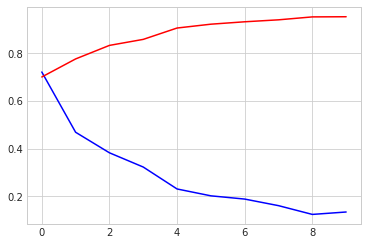

In [128]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['acc'], color='r')
plt.show()

In [129]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = composite_model.predict([x_test, x_test_fft])[:,0]

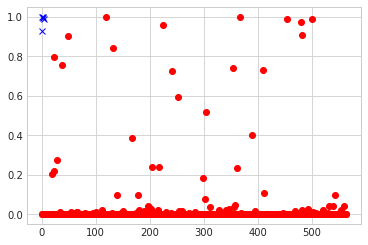

In [131]:
plt.plot([y_hat[i] for i in yes_idx], 'bx')

plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Also, almost all negative examples get score close to zero, except a few in the 0.9-1.0 range. This is encouraging.

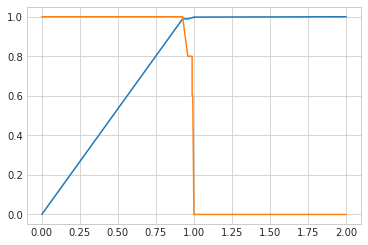

Crossover at 0.93 with specificity 0.99


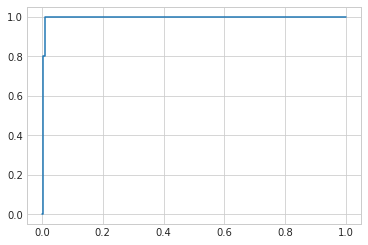

ROC area under curve is 0.99


In [132]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

We now choose an optimal cutoff score for classification. Sklearn can help us with this.

In [138]:
predictions = [y>crossover_cutoff for y in y_hat]
F1_score(predictions, y_test, crossover_cutoff)

found:  10
actual:  5
missed:  1
precision:  0.4
recall:  0.8
F1:  0.5333333333333333


0.5333333333333333

F1 Score

# Benchmark

Random forest

In [57]:
#generate one-hot classifications
y_train_1hot = np.array([[1,0] if y > 0.5 else [0, 1] for y in y_train])
y_test_1hot = [[1,0] if y > 0.5 else [0, 1] for y in y_test]

print('x_train_fft_raw',x_train_fft_raw.shape)
print('y_train_1hot', y_train_1hot)

x_train_fft_raw (5087, 3197)
y_train_1hot [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
# Import the model 
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model with 1000 trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose=1)

# Train the model on training data
rf.fit(x_train_fft_raw, y_train_1hot )

In [ ]:
# predict on the test data
predictions = rf.predict(x_test_fft_raw)

In [217]:
# analyse
F1_score_1hot(predictions, y_test)

found: 0
actual: 5
missed: 5
precision: 0.0
recall: 0.0
F1: 0.0


0.0

In [212]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]

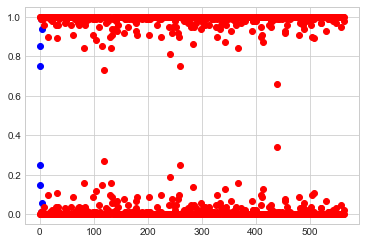

In [214]:
plt.plot([predictions[i] for i in yes_idx], 'bo')

plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()